# Tutorial - Wind Power Prediction Using Gaussian Processes

***Machine Learning for Renewable Energy Systems***

**Timo Lübbing**

**University of Tübingen**

#### Introduction

This tutorial explores the application of Gaussian Processes (GP) in forecasting wind power generation. Through a series of code examples and explanations, you'll gain insights into data preprocessing, feature engineering, and the training and evaluation of GP models for wind energy prediction.

Additionally, we'll examine how different weather input features influence the model's performance.

#### The Data

We have access to the realised energy supply for various energy sources in germany, including on and offshore wind production. In addition, we have access to numerical weather data. Both datasets contain time series data with a 15-minute resolution, covering the perio from 2019 to to 2023. 

#### Preprocessing

Lets get started by loading the data and looking at it.

In [1]:
import sys
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import properscoring as ps

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV
from torch.utils.data import DataLoader, TensorDataset

sys.path.append(str(Path("..").resolve()))
from src.visualizations import (
    setup_tueplots,
    plot_wind_power_composition,
    plot_wind_speed_components,
)
from src.preprocessing import (
    Column,
    preprocess_supply_data,
    weather_germany_mean,
    weather_germany_clustered,
    create_time_features,
    create_sliding_window_data,
)
from src.checkpoint import save_checkpoint, load_checkpoint

**Load the Energy Supply Data**

In [2]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')
df.head(2)

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75


Proprocessing steps for the energy supply data include:
- Convert to datetime index
- Resample 15-minute intervals to hourly data
- Convert non-numeric columns to float type
- Add a column for the sum of on and offshore wind production. This will be our target variable for the model.

In [3]:
df = preprocess_supply_data(df, resample="h")
df.head(2)

,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW],Wind Sum [MW]
Date from,,,,,,,,,,,,,
2019-01-01 00:00:00,4815.25,85420,3134.00,20391.75,0.0,1260,9001.50,6335.0,2811.75,3273.25,271.75,133590,23525.75
2019-01-01 01:00:00,4808.75,50480,2868.25,22365.50,0.0,1260,8535.25,5379.5,2404.25,2967.25,21.50,130290,25233.75


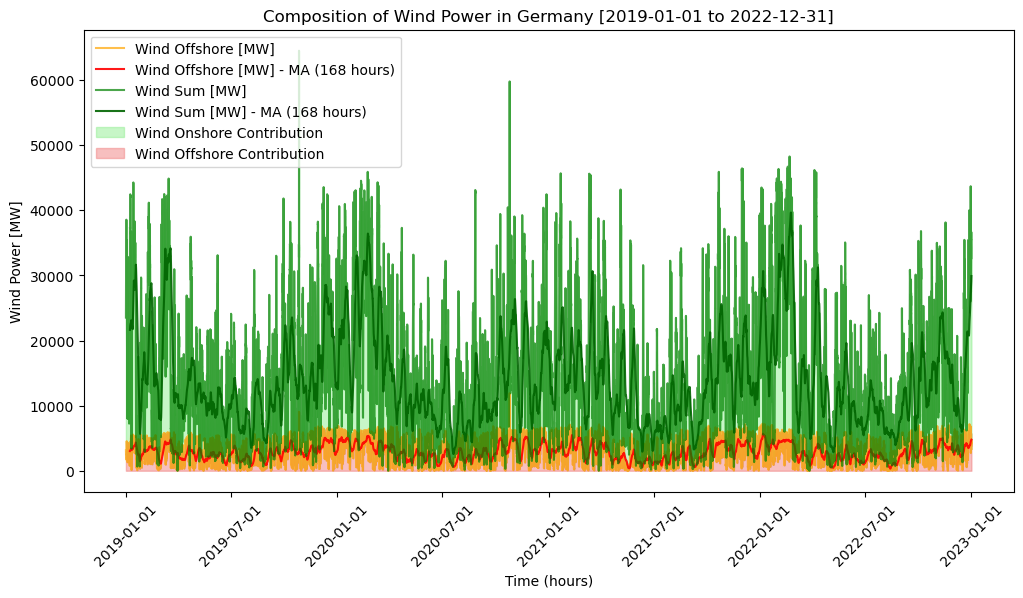

In [4]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

**Wind Power Composition**

We can already see a clear seasonal pattern in the onshore wind production. The offshore wind production is more stable, but also shows some seasonal patterns. Overall, the total wind power production underlies strong noise.

The following code visulalizes the composition of just a single year:

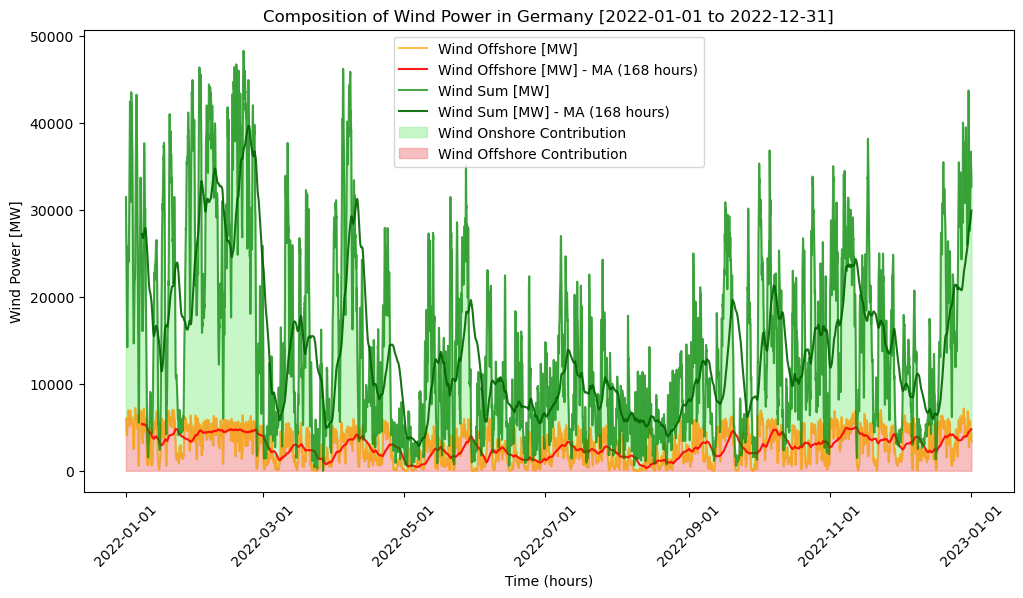

In [5]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2022-12-31"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

**Target Sum of On and Offshore Wind Production**

The below plot shows the total wind power production in Germany for the year 2022. This time series is our target and the year we want to predict within the test set.

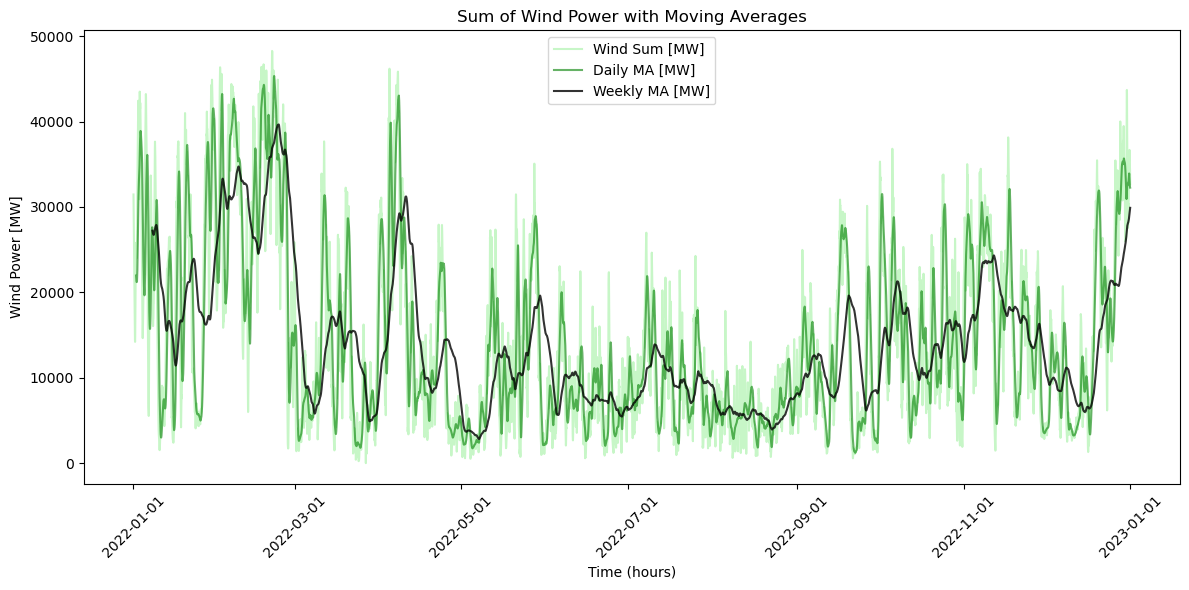

In [6]:
wind = df_indexed[Column.WIND.value]
dates = df_indexed.index

# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="black", alpha=0.8)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Load the Weather Data**

In [7]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather_2022_path = Path('..') / "data" / "Weather_Data_Germany_2022.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')
weather_2022 = pd.read_csv(weather_2022_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


Preprocessing steps for the weather data include:
- Convert to datetime index
- Weather data is already in hourly resolution, so no resampling is needed
- Concatenate the disjoint yearly dataframes
- Average the weather data in germany over all weather stations recorded in the dataset.

In [8]:
def format_weather_time(weather: pd.DataFrame) -> None:
    """Formats weather data time column and sets it as index."""
    weather.drop(columns=["forecast_origin"], inplace=True)
    weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
    weather.set_index("time", inplace=True)
    weather.sort_index(inplace=True)

format_weather_time(weather)
format_weather_time(weather_2022)

weather = pd.concat([weather, weather_2022], axis=0)

In [9]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False  # Default: False to reduce complexity

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
else:
    weather = weather_germany_mean(weather)

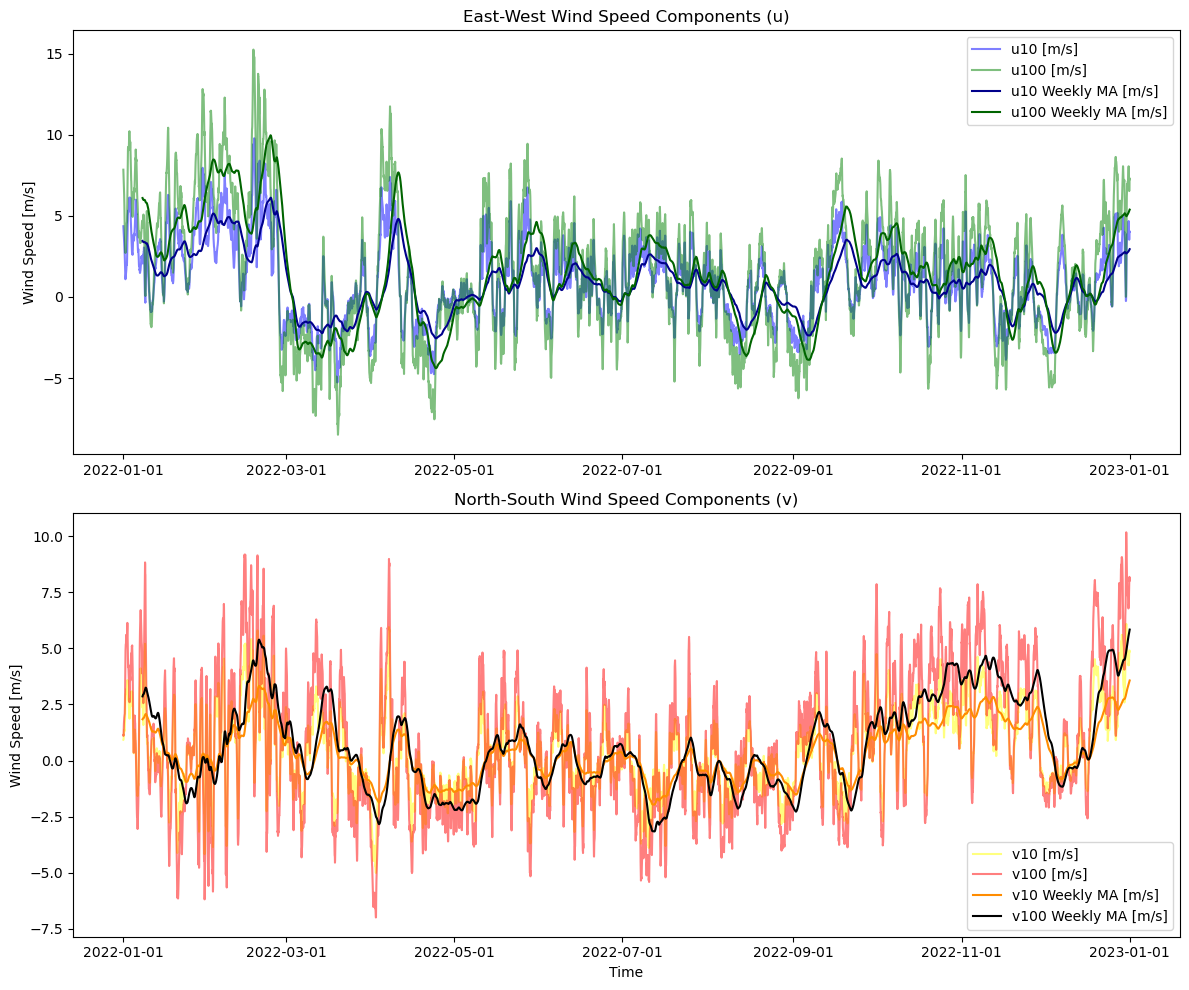

In [10]:
weather_indexed = weather["2022-01-01":"2022-12-31"]
plot_wind_speed_components(weather_indexed)

**Join the Dataframes**

In [11]:
# Join weather data with wind data
target = df[[Column.WIND.value]].copy()
dataframe = target.join(weather, how="inner")

### **Machine Learning Setup for Forecasting**

At this point in the tutorial we already loaded the given data, looked at the data and provided some basic preprocessing steps. Now, the time series data is aligned and ready for further processing and modeling in the machine learning setup. For time series forecasting, we will need to continue with the following steps to prepare the data for successful and efficient modeling and forecasting:

1. **Split data into training and testing sets**
   
   Carefully split the data in the time series context: Keep the `temporal order` intact and ensure that the training set prcedes the test set. This is crucial for time series forecasting to avoid data leakage and ensure that the model learns from past data to predict future values. 

2. **Feature engineering**
   
   - Create `time-based features` such as month of the year.
   - Use current weather data as `additional features`
   - Create `lagged features` to capture temporal dependencies in the data. (See sliding window approach below)
   - `Feature scaling`: Normalize or standardize the features to ensure that they are on a similar scale, which is particularly important for Gaussian Processes.
  
3. **Sliding window approach for time series forecasting**
   
   Implement a sliding window approach to create training samples. This involves defining a `window size` that determines how many past observations will be used to predict the next value. The window slides over the time series, creating training samples that consist of the past observations (lagged features), any additional features, and the target variable (the value to be predicted). We can further define the `forecast horizon` (hours) to predict ahead, which will determine how many future values we want to forecast based on the past observations. 
   
4. **Feature selection**
   After feature engineering, it's important to select relevant features that contribute significantly to the model's performance. This reduces complexity and significantly improves computational efficiency. The following methods can be used for feature selection:
   - Mutual Information, Pearson Correlation, Autocorrelation
   - Fit a Lasso regression model and select features based on coefficients (try LassoCV)

**Train and test set split**

Train years: 2019, 2020, 2021

Test year: 2022

In [12]:
# Train and test split
SPLIT_DATE = "2022-01-01"
START_DATE = df.index[0]
END_DATE = df.index[-1]

train_data = dataframe[START_DATE:SPLIT_DATE]
test_data = dataframe[SPLIT_DATE:END_DATE]

**Create Time Features**

Sine and cosine transformations of...
- the hour of the day
- the day of the week
- the month of the year
- the day of the year

In [13]:
# Create time features
train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

**Standardize the target variable (Wind Sum [MW])**

Transform the target variable to have a mean of 0 and a standard deviation of 1. This is important for Gaussian Processes, as they assume that the target variable is normally distributed. The test data will be standardized using the mean and standard deviation of the training data.

In [14]:
# Scale target variable
target_scaler = StandardScaler()
train_data.loc[:, [Column.WIND.value]] = target_scaler.fit_transform(
    train_data.loc[:, [Column.WIND.value]]
)
test_data.loc[:, [Column.WIND.value]] = target_scaler.transform(
    test_data.loc[:, [Column.WIND.value]]
)

**Create Training and Test samples using a sliding window approach**

In [15]:
# Sliding window training
HISTORY_LENGTH = 24  # 24 hours (lag features)
FORECAST_HORIZON = 24  # 24 hours

X_df, y_df = create_sliding_window_data(
    data=train_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
X_test_df, y_test_df = create_sliding_window_data(
    data=test_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
print(X_df.columns)

Index(['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18',
       'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11',
       'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3',
       'lag_2', 'lag_1', 'cdir', 'z', 'msl', 'blh', 'tcc', 'u10', 'v10', 't2m',
       'ssr', 'tsr', 'sund', 'tp', 'fsr', 'u100', 'v100', 'hour_sin',
       'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')


In [16]:
lag_feature_names = [col for col in X_df.columns if col.startswith("lag_")]
time_feature_names = [col for col in X_df.columns if col.endswith("_sin") or col.endswith("_cos")]
weather_feature_names = list(set(X_df.columns) - set(lag_feature_names) - set(time_feature_names))

**Standardize the weather data**

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("weather", StandardScaler(), weather_feature_names),
        ("time", "passthrough", time_feature_names),  # already scaled
        ("lag", "passthrough", lag_feature_names),  # already scaled with target variable
    ],
    remainder="drop",
)

In [18]:
X_np = preprocessor.fit_transform(X_df)
X_test_np = preprocessor.transform(X_test_df)
X_df = pd.DataFrame(X_np, columns=X_df.columns)
X_test_df = pd.DataFrame(X_test_np, columns=X_test_df.columns)

**Feature Selection**:

In [19]:
# Feature selection methods
selected_lag_features = ["lag_1", "lag_2", "lag_3", "lag_4", "lag_6", "lag_8", "lag_10", "lag_12", "lag_18", "lag_24"]
selected_time_features = ["dayofyear_cos", "month_sin"]
selected_weather_features = ["u100", "v100", "t2m", "ssr"]

selected_features = selected_lag_features + selected_time_features + selected_weather_features
X_df = X_df[selected_features]
X_test_df = X_test_df[selected_features]

#### **Gaussian Process Forecasting**

Gaussian Processes (GP) are a powerful non-parametric Bayesian approach for regression tasks. An exact GP consists of mean and covariance functions that define the distribution over functions. The covariance function, also known as the kernel, captures the relationships between all data points in the input space. 

Thus, the resulting kernel matrix is of size `n x n`, where `n` is the number of training samples. This results in a computational complexity of O(n^3) for training, which can become intractable for large datasets. In addition, the kernel matrix is dense, leading to high memory consumption. 

In our wind power prediction task, we have a large number of training samples and high dimensional multivariate data, which makes exact Gaussian Processes impractical. We will use Approximate Gaussian Processes to handle the scalability issues.

**Approximate GPs**, particularly variational sparse GPs, offer a powerful and scalable way to apply Gaussian process models to larger datasets by using inducing points to create a low-rank approximation and optimizing a variational lower bound (ELBO) on the true marginal likelihood.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
# Transform data to torch tensors
float_precision = torch.float32

X = torch.tensor(X_df.values, dtype=float_precision, device=device)
y = torch.tensor(y_df.values, dtype=float_precision, device=device)
X_test = torch.tensor(X_test_df.values, dtype=float_precision, device=device)
y_test = torch.tensor(y_test_df.values, dtype=float_precision, device=device)
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([26281, 16]),
 torch.Size([26281, 24]),
 torch.Size([8713, 16]),
 torch.Size([8713, 24]))

**Stochastic Variational Gaussian Processes (SVGP)**

Introducing Inducing Variables (Support Points): A small set of $M$ inducing variables $u = f(Z)$ corresponding to $M$ inducing input locations $Z = {z_1, ..., z_M}$. These inducing variables act as a summary or bottleneck for the information from the full dataset.

Variational Inference: Instead of directly computing the intractable posterior over function values $p(f|y)$, SVGP approximates it with a simpler variational distribution $q(f)$.

Stochastic Optimization: The objective function (the ELBO) is structured such that it can be optimized using mini-batches of data, allowing training on large datasets.

In [22]:
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational Distribution & Strategy
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.PeriodicKernel() +
            gpytorch.kernels.LinearKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


**Define the GP Models**

We build a set of 24 SVGP models, one for each hour of the forecasting horizon ($h$). Each model will be trained to predict the wind power production for forecast $t+h$ given the past $t-24, ..., t-1$ observations and current weather data at time $t$.

The number of inducing points is defined to be $M=1000$. This is a trade-off between computational efficiency, memory constraints and model performance.

You are able to load pretrained models from the `models` directory. If you want to train the models yourself, you can set the `load_pretrained` variable to `False`. This will take a while, so be patient.

In [ ]:
M_INDUCING_POINTS = 1000
LOAD_PRETRAINED = True
CHECKPOINT_NAME = f"checkpoint_v2_M{M_INDUCING_POINTS}"

models = []
likelihoods = []
mlls = []
optimizers = []
model_current_epochs = [0] * FORECAST_HORIZON

inducing_points_candidates = X[
    torch.randperm(X.size(0))[: max(M_INDUCING_POINTS, X.size(0))]
]  # Ensure we don't exceed X size

for h in range(FORECAST_HORIZON):
    # Select M inducing points from the candidates with resampling
    current_inducing_points = inducing_points_candidates[
        torch.randperm(inducing_points_candidates.size(0))[:M_INDUCING_POINTS]
    ]

    model_h = SparseGPModel(current_inducing_points).to(device)
    noise_prior_h = gpytorch.priors.GammaPrior(
        concentration=1.1,
        rate=11.0
    )  # This prior has a mean of 0.1 and a variance of 1.1 / 11.0^2 = 0.009
    likelihood_h = gpytorch.likelihoods.GaussianLikelihood(
        noise_prior=noise_prior_h,
        noise_constraint=gpytorch.constraints.GreaterThan(1e-6)
    ).to(device)
    mll_h = gpytorch.mlls.VariationalELBO(
        likelihood_h, model_h, num_data=X.size(0)
    ).to(device)

    optimizer_h = torch.optim.AdamW(
        [
            {"params": model_h.parameters()},
            {"params": likelihood_h.parameters()},
        ],
        lr=0.01,
    )
    
    if LOAD_PRETRAINED:
        try:
            epoch_h = load_checkpoint(model_h, likelihood_h, optimizer_h, h, CHECKPOINT_NAME)
            model_current_epochs[h] = epoch_h
            print(f"Loaded checkpoint for horizon {h} at epoch {epoch_h}.")
        except FileNotFoundError:
            model_current_epochs[h] = 0
    else:
        model_current_epochs[h] = 0

    models.append(model_h)
    likelihoods.append(likelihood_h)
    mlls.append(mll_h)
    optimizers.append(optimizer_h)

print(f"\nInitialized {len(models)} models. Current epochs: {model_current_epochs}")


Loaded checkpoint for horizon 0 at epoch 30.
Loaded checkpoint for horizon 1 at epoch 20.
Loaded checkpoint for horizon 2 at epoch 20.
Loaded checkpoint for horizon 3 at epoch 10.
Loaded checkpoint for horizon 4 at epoch 10.
Loaded checkpoint for horizon 5 at epoch 10.
Loaded checkpoint for horizon 6 at epoch 10.
Loaded checkpoint for horizon 7 at epoch 10.
Loaded checkpoint for horizon 8 at epoch 10.
Loaded checkpoint for horizon 9 at epoch 10.
Loaded checkpoint for horizon 10 at epoch 10.
Loaded checkpoint for horizon 11 at epoch 10.
Loaded checkpoint for horizon 12 at epoch 10.
Loaded checkpoint for horizon 13 at epoch 10.
Loaded checkpoint for horizon 14 at epoch 10.
Loaded checkpoint for horizon 15 at epoch 10.
Loaded checkpoint for horizon 16 at epoch 10.
Loaded checkpoint for horizon 17 at epoch 10.
Loaded checkpoint for horizon 18 at epoch 10.
Loaded checkpoint for horizon 19 at epoch 10.
Loaded checkpoint for horizon 20 at epoch 10.
Loaded checkpoint for horizon 21 at epoch 10

**Train the SVGP Models**

For each forecast horizon we can train a separate SVGP model. The training process involves optimizing the variational parameters to maximize the Evidence Lower Bound (ELBO) on the marginal likelihood of the data. 

Transforming the data into a torch TensorDataset allows for efficient batching as SVGP training allows for mini-batch stochastic optimization. The batch size can be set based on the available GPU memory. 

In [36]:
CONTINUE_TRAINING = True
NUM_EPOCHS = 100
BATCH_SIZE = 1024 * 2

if CONTINUE_TRAINING:
    for h in range(FORECAST_HORIZON):
        print(
            f"\nTraining model for forecast step {h+1}/{FORECAST_HORIZON} "
            f"starting from epoch {model_current_epochs[h]}."
        )
        model = models[h]
        likelihood = likelihoods[h]
        mll = mlls[h]
        optimizer = optimizers[h]

        # Get the target for the current forecast step
        current_train_y = y[:, h]
        train_dataset = TensorDataset(X, current_train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        model.train()
        likelihood.train()
        
        start_epoch_h = model_current_epochs[h]

        for epoch_in_session in tqdm(range(NUM_EPOCHS)):
            cumulative_epoch = start_epoch_h + epoch_in_session
            epoch_loss = 0.0
            
            for X_batch, y_batch in train_loader:
            
                optimizer.zero_grad()
                output = model(X_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                
            epoch_loss /= len(train_loader)
            if (epoch_in_session + 1) % 5 == 0:
                print(f" Epoch {cumulative_epoch}/{NUM_EPOCHS+start_epoch_h} -"
                      f" ELBO Loss: {epoch_loss:.3f}")

        # Save the model checkpoint
        final_epoch_h = start_epoch_h + NUM_EPOCHS
        save_checkpoint(final_epoch_h, h, model, likelihood, optimizer, CHECKPOINT_NAME)
        model_current_epochs[h] = final_epoch_h
else:
    print("Training is skipped. Set CONTINUE_TRAINING to True to train the models.")
    if LOAD_PRETRAINED:
        print(f"Models loaded with epochs: {model_current_epochs}")



Training model for forecast step 1/24 starting from epoch 30.


  5%|▌         | 5/100 [00:14<04:30,  2.84s/it]

 Epoch 34/130 - ELBO Loss: 0.171


 10%|█         | 10/100 [00:28<04:16,  2.85s/it]

 Epoch 39/130 - ELBO Loss: -0.014


 15%|█▌        | 15/100 [00:42<04:03,  2.86s/it]

 Epoch 44/130 - ELBO Loss: -0.190


 20%|██        | 20/100 [00:56<03:48,  2.86s/it]

 Epoch 49/130 - ELBO Loss: -0.346


 25%|██▌       | 25/100 [01:11<03:34,  2.86s/it]

 Epoch 54/130 - ELBO Loss: -0.478


 30%|███       | 30/100 [01:25<03:20,  2.86s/it]

 Epoch 59/130 - ELBO Loss: -0.603


 35%|███▌      | 35/100 [01:40<03:07,  2.88s/it]

 Epoch 64/130 - ELBO Loss: -0.716


 40%|████      | 40/100 [01:54<02:53,  2.89s/it]

 Epoch 69/130 - ELBO Loss: -0.768


 45%|████▌     | 45/100 [02:09<02:38,  2.88s/it]

 Epoch 74/130 - ELBO Loss: -0.794


 50%|█████     | 50/100 [02:23<02:24,  2.89s/it]

 Epoch 79/130 - ELBO Loss: -0.816


 55%|█████▌    | 55/100 [02:38<02:11,  2.91s/it]

 Epoch 84/130 - ELBO Loss: -0.830


 60%|██████    | 60/100 [02:52<01:56,  2.91s/it]

 Epoch 89/130 - ELBO Loss: -0.832


 65%|██████▌   | 65/100 [03:07<01:42,  2.93s/it]

 Epoch 94/130 - ELBO Loss: -0.843


 70%|███████   | 70/100 [03:21<01:28,  2.93s/it]

 Epoch 99/130 - ELBO Loss: -0.845


 75%|███████▌  | 75/100 [03:36<01:12,  2.90s/it]

 Epoch 104/130 - ELBO Loss: -0.855


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 109/130 - ELBO Loss: -0.856


 85%|████████▌ | 85/100 [04:05<00:43,  2.89s/it]

 Epoch 114/130 - ELBO Loss: -0.856


 90%|█████████ | 90/100 [04:19<00:29,  2.92s/it]

 Epoch 119/130 - ELBO Loss: -0.855


 95%|█████████▌| 95/100 [04:34<00:14,  2.91s/it]

 Epoch 124/130 - ELBO Loss: -0.860


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


 Epoch 129/130 - ELBO Loss: -0.869
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_0.pt

Training model for forecast step 2/24 starting from epoch 20.


  5%|▌         | 5/100 [00:14<04:33,  2.88s/it]

 Epoch 24/120 - ELBO Loss: 0.601


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 29/120 - ELBO Loss: 0.452


 15%|█▌        | 15/100 [00:43<04:09,  2.93s/it]

 Epoch 34/120 - ELBO Loss: 0.305


 20%|██        | 20/100 [00:58<03:54,  2.93s/it]

 Epoch 39/120 - ELBO Loss: 0.167


 25%|██▌       | 25/100 [01:12<03:38,  2.91s/it]

 Epoch 44/120 - ELBO Loss: 0.047


 30%|███       | 30/100 [01:27<03:23,  2.91s/it]

 Epoch 49/120 - ELBO Loss: -0.054


 35%|███▌      | 35/100 [01:41<03:09,  2.91s/it]

 Epoch 54/120 - ELBO Loss: -0.168


 40%|████      | 40/100 [01:56<02:54,  2.90s/it]

 Epoch 59/120 - ELBO Loss: -0.237


 45%|████▌     | 45/100 [02:10<02:39,  2.91s/it]

 Epoch 64/120 - ELBO Loss: -0.272


 50%|█████     | 50/100 [02:25<02:24,  2.90s/it]

 Epoch 69/120 - ELBO Loss: -0.293


 55%|█████▌    | 55/100 [02:40<02:12,  2.94s/it]

 Epoch 74/120 - ELBO Loss: -0.305


 60%|██████    | 60/100 [02:54<01:56,  2.91s/it]

 Epoch 79/120 - ELBO Loss: -0.316


 65%|██████▌   | 65/100 [03:09<01:41,  2.89s/it]

 Epoch 84/120 - ELBO Loss: -0.324


 70%|███████   | 70/100 [03:23<01:26,  2.87s/it]

 Epoch 89/120 - ELBO Loss: -0.330


 75%|███████▌  | 75/100 [03:37<01:11,  2.88s/it]

 Epoch 94/120 - ELBO Loss: -0.335


 80%|████████  | 80/100 [03:52<00:58,  2.91s/it]

 Epoch 99/120 - ELBO Loss: -0.339


 85%|████████▌ | 85/100 [04:07<00:43,  2.90s/it]

 Epoch 104/120 - ELBO Loss: -0.342


 90%|█████████ | 90/100 [04:21<00:29,  2.91s/it]

 Epoch 109/120 - ELBO Loss: -0.345


 95%|█████████▌| 95/100 [04:35<00:14,  2.91s/it]

 Epoch 114/120 - ELBO Loss: -0.345


100%|██████████| 100/100 [04:50<00:00,  2.90s/it]


 Epoch 119/120 - ELBO Loss: -0.350
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_1.pt

Training model for forecast step 3/24 starting from epoch 20.


  5%|▌         | 5/100 [00:14<04:31,  2.86s/it]

 Epoch 24/120 - ELBO Loss: 0.664


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 29/120 - ELBO Loss: 0.540


 15%|█▌        | 15/100 [00:43<04:04,  2.87s/it]

 Epoch 34/120 - ELBO Loss: 0.424


 20%|██        | 20/100 [00:57<03:50,  2.88s/it]

 Epoch 39/120 - ELBO Loss: 0.323


 25%|██▌       | 25/100 [01:11<03:35,  2.87s/it]

 Epoch 44/120 - ELBO Loss: 0.245


 30%|███       | 30/100 [01:26<03:21,  2.87s/it]

 Epoch 49/120 - ELBO Loss: 0.183


 35%|███▌      | 35/100 [01:40<03:06,  2.86s/it]

 Epoch 54/120 - ELBO Loss: 0.137


 40%|████      | 40/100 [01:54<02:51,  2.87s/it]

 Epoch 59/120 - ELBO Loss: 0.107


 45%|████▌     | 45/100 [02:09<02:36,  2.85s/it]

 Epoch 64/120 - ELBO Loss: 0.084


 50%|█████     | 50/100 [02:23<02:22,  2.86s/it]

 Epoch 69/120 - ELBO Loss: 0.067


 55%|█████▌    | 55/100 [02:38<02:10,  2.90s/it]

 Epoch 74/120 - ELBO Loss: 0.052


 60%|██████    | 60/100 [02:52<01:55,  2.90s/it]

 Epoch 79/120 - ELBO Loss: 0.029


 65%|██████▌   | 65/100 [03:07<01:41,  2.89s/it]

 Epoch 84/120 - ELBO Loss: 0.012


 70%|███████   | 70/100 [03:21<01:26,  2.89s/it]

 Epoch 89/120 - ELBO Loss: -0.001


 75%|███████▌  | 75/100 [03:35<01:12,  2.89s/it]

 Epoch 94/120 - ELBO Loss: -0.009


 80%|████████  | 80/100 [03:50<00:57,  2.90s/it]

 Epoch 99/120 - ELBO Loss: -0.017


 85%|████████▌ | 85/100 [04:04<00:43,  2.88s/it]

 Epoch 104/120 - ELBO Loss: -0.020


 90%|█████████ | 90/100 [04:18<00:28,  2.88s/it]

 Epoch 109/120 - ELBO Loss: -0.025


 95%|█████████▌| 95/100 [04:33<00:14,  2.86s/it]

 Epoch 114/120 - ELBO Loss: -0.027


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


 Epoch 119/120 - ELBO Loss: -0.027
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_2.pt

Training model for forecast step 4/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:31,  2.86s/it]

 Epoch 14/110 - ELBO Loss: 1.128


 10%|█         | 10/100 [00:28<04:17,  2.86s/it]

 Epoch 19/110 - ELBO Loss: 1.033


 15%|█▌        | 15/100 [00:42<04:01,  2.84s/it]

 Epoch 24/110 - ELBO Loss: 0.936


 20%|██        | 20/100 [00:57<03:49,  2.86s/it]

 Epoch 29/110 - ELBO Loss: 0.833


 25%|██▌       | 25/100 [01:11<03:34,  2.85s/it]

 Epoch 34/110 - ELBO Loss: 0.728


 30%|███       | 30/100 [01:25<03:18,  2.84s/it]

 Epoch 39/110 - ELBO Loss: 0.626


 35%|███▌      | 35/100 [01:40<03:10,  2.93s/it]

 Epoch 44/110 - ELBO Loss: 0.536


 40%|████      | 40/100 [01:55<02:56,  2.94s/it]

 Epoch 49/110 - ELBO Loss: 0.460


 45%|████▌     | 45/100 [02:09<02:40,  2.92s/it]

 Epoch 54/110 - ELBO Loss: 0.402


 50%|█████     | 50/100 [02:24<02:26,  2.92s/it]

 Epoch 59/110 - ELBO Loss: 0.358


 55%|█████▌    | 55/100 [02:38<02:12,  2.94s/it]

 Epoch 64/110 - ELBO Loss: 0.325


 60%|██████    | 60/100 [02:53<01:57,  2.95s/it]

 Epoch 69/110 - ELBO Loss: 0.284


 65%|██████▌   | 65/100 [03:08<01:41,  2.91s/it]

 Epoch 74/110 - ELBO Loss: 0.250


 70%|███████   | 70/100 [03:22<01:27,  2.93s/it]

 Epoch 79/110 - ELBO Loss: 0.229


 75%|███████▌  | 75/100 [03:37<01:12,  2.90s/it]

 Epoch 84/110 - ELBO Loss: 0.215


 80%|████████  | 80/100 [03:51<00:58,  2.90s/it]

 Epoch 89/110 - ELBO Loss: 0.207


 85%|████████▌ | 85/100 [04:06<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 0.201


 90%|█████████ | 90/100 [04:20<00:28,  2.86s/it]

 Epoch 99/110 - ELBO Loss: 0.196


 95%|█████████▌| 95/100 [04:35<00:14,  2.93s/it]

 Epoch 104/110 - ELBO Loss: 0.193


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


 Epoch 109/110 - ELBO Loss: 0.189
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_3.pt

Training model for forecast step 5/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:37,  2.92s/it]

 Epoch 14/110 - ELBO Loss: 1.155


 10%|█         | 10/100 [00:29<04:21,  2.91s/it]

 Epoch 19/110 - ELBO Loss: 1.068


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 0.983


 20%|██        | 20/100 [00:57<03:50,  2.88s/it]

 Epoch 29/110 - ELBO Loss: 0.894


 25%|██▌       | 25/100 [01:12<03:37,  2.90s/it]

 Epoch 34/110 - ELBO Loss: 0.804


 30%|███       | 30/100 [01:26<03:21,  2.88s/it]

 Epoch 39/110 - ELBO Loss: 0.720


 35%|███▌      | 35/100 [01:41<03:06,  2.88s/it]

 Epoch 44/110 - ELBO Loss: 0.645


 40%|████      | 40/100 [01:55<02:52,  2.88s/it]

 Epoch 49/110 - ELBO Loss: 0.583


 45%|████▌     | 45/100 [02:10<02:38,  2.88s/it]

 Epoch 54/110 - ELBO Loss: 0.536


 50%|█████     | 50/100 [02:24<02:24,  2.90s/it]

 Epoch 59/110 - ELBO Loss: 0.498


 55%|█████▌    | 55/100 [02:39<02:10,  2.90s/it]

 Epoch 64/110 - ELBO Loss: 0.469


 60%|██████    | 60/100 [02:53<01:56,  2.91s/it]

 Epoch 69/110 - ELBO Loss: 0.432


 65%|██████▌   | 65/100 [03:08<01:43,  2.95s/it]

 Epoch 74/110 - ELBO Loss: 0.396


 70%|███████   | 70/100 [03:22<01:26,  2.89s/it]

 Epoch 79/110 - ELBO Loss: 0.378


 75%|███████▌  | 75/100 [03:37<01:12,  2.89s/it]

 Epoch 84/110 - ELBO Loss: 0.367


 80%|████████  | 80/100 [03:51<00:57,  2.90s/it]

 Epoch 89/110 - ELBO Loss: 0.356


 85%|████████▌ | 85/100 [04:06<00:43,  2.91s/it]

 Epoch 94/110 - ELBO Loss: 0.352


 90%|█████████ | 90/100 [04:20<00:28,  2.88s/it]

 Epoch 99/110 - ELBO Loss: 0.348


 95%|█████████▌| 95/100 [04:34<00:14,  2.87s/it]

 Epoch 104/110 - ELBO Loss: 0.344


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


 Epoch 109/110 - ELBO Loss: 0.341
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_4.pt

Training model for forecast step 6/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.177


 10%|█         | 10/100 [00:29<04:20,  2.89s/it]

 Epoch 19/110 - ELBO Loss: 1.098


 15%|█▌        | 15/100 [00:43<04:07,  2.91s/it]

 Epoch 24/110 - ELBO Loss: 1.020


 20%|██        | 20/100 [00:58<03:54,  2.93s/it]

 Epoch 29/110 - ELBO Loss: 0.942


 25%|██▌       | 25/100 [01:12<03:37,  2.90s/it]

 Epoch 34/110 - ELBO Loss: 0.865


 30%|███       | 30/100 [01:27<03:24,  2.91s/it]

 Epoch 39/110 - ELBO Loss: 0.792


 35%|███▌      | 35/100 [01:41<03:08,  2.91s/it]

 Epoch 44/110 - ELBO Loss: 0.730


 40%|████      | 40/100 [01:56<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 0.679


 45%|████▌     | 45/100 [02:10<02:39,  2.90s/it]

 Epoch 54/110 - ELBO Loss: 0.637


 50%|█████     | 50/100 [02:25<02:25,  2.90s/it]

 Epoch 59/110 - ELBO Loss: 0.600


 55%|█████▌    | 55/100 [02:39<02:10,  2.90s/it]

 Epoch 64/110 - ELBO Loss: 0.552


 60%|██████    | 60/100 [02:53<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 0.524


 65%|██████▌   | 65/100 [03:08<01:40,  2.86s/it]

 Epoch 74/110 - ELBO Loss: 0.504


 70%|███████   | 70/100 [03:22<01:26,  2.88s/it]

 Epoch 79/110 - ELBO Loss: 0.491


 75%|███████▌  | 75/100 [03:37<01:12,  2.88s/it]

 Epoch 84/110 - ELBO Loss: 0.485


 80%|████████  | 80/100 [03:51<00:57,  2.86s/it]

 Epoch 89/110 - ELBO Loss: 0.478


 85%|████████▌ | 85/100 [04:05<00:42,  2.84s/it]

 Epoch 94/110 - ELBO Loss: 0.473


 90%|█████████ | 90/100 [04:20<00:28,  2.86s/it]

 Epoch 99/110 - ELBO Loss: 0.467


 95%|█████████▌| 95/100 [04:34<00:14,  2.91s/it]

 Epoch 104/110 - ELBO Loss: 0.465


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


 Epoch 109/110 - ELBO Loss: 0.464
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_5.pt

Training model for forecast step 7/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.203


 10%|█         | 10/100 [00:28<04:22,  2.92s/it]

 Epoch 19/110 - ELBO Loss: 1.128


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 1.058


 20%|██        | 20/100 [00:57<03:52,  2.90s/it]

 Epoch 29/110 - ELBO Loss: 0.988


 25%|██▌       | 25/100 [01:12<03:37,  2.90s/it]

 Epoch 34/110 - ELBO Loss: 0.920


 30%|███       | 30/100 [01:26<03:22,  2.89s/it]

 Epoch 39/110 - ELBO Loss: 0.857


 35%|███▌      | 35/100 [01:41<03:07,  2.89s/it]

 Epoch 44/110 - ELBO Loss: 0.803


 40%|████      | 40/100 [01:55<02:53,  2.89s/it]

 Epoch 49/110 - ELBO Loss: 0.759


 45%|████▌     | 45/100 [02:09<02:37,  2.86s/it]

 Epoch 54/110 - ELBO Loss: 0.724


 50%|█████     | 50/100 [02:24<02:22,  2.86s/it]

 Epoch 59/110 - ELBO Loss: 0.679


 55%|█████▌    | 55/100 [02:38<02:09,  2.88s/it]

 Epoch 64/110 - ELBO Loss: 0.632


 60%|██████    | 60/100 [02:53<01:54,  2.86s/it]

 Epoch 69/110 - ELBO Loss: 0.607


 65%|██████▌   | 65/100 [03:07<01:40,  2.86s/it]

 Epoch 74/110 - ELBO Loss: 0.593


 70%|███████   | 70/100 [03:21<01:26,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 0.582


 75%|███████▌  | 75/100 [03:36<01:12,  2.90s/it]

 Epoch 84/110 - ELBO Loss: 0.576


 80%|████████  | 80/100 [03:51<00:58,  2.93s/it]

 Epoch 89/110 - ELBO Loss: 0.571


 85%|████████▌ | 85/100 [04:05<00:44,  2.94s/it]

 Epoch 94/110 - ELBO Loss: 0.566


 90%|█████████ | 90/100 [04:20<00:29,  2.92s/it]

 Epoch 99/110 - ELBO Loss: 0.563


 95%|█████████▌| 95/100 [04:34<00:14,  2.93s/it]

 Epoch 104/110 - ELBO Loss: 0.561


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


 Epoch 109/110 - ELBO Loss: 0.558
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_6.pt

Training model for forecast step 8/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:36,  2.91s/it]

 Epoch 14/110 - ELBO Loss: 1.224


 10%|█         | 10/100 [00:29<04:27,  2.97s/it]

 Epoch 19/110 - ELBO Loss: 1.153


 15%|█▌        | 15/100 [00:44<04:12,  2.97s/it]

 Epoch 24/110 - ELBO Loss: 1.088


 20%|██        | 20/100 [00:59<03:57,  2.97s/it]

 Epoch 29/110 - ELBO Loss: 1.025


 25%|██▌       | 25/100 [01:14<03:41,  2.95s/it]

 Epoch 34/110 - ELBO Loss: 0.964


 30%|███       | 30/100 [01:29<03:27,  2.96s/it]

 Epoch 39/110 - ELBO Loss: 0.910


 35%|███▌      | 35/100 [01:43<03:11,  2.94s/it]

 Epoch 44/110 - ELBO Loss: 0.862


 40%|████      | 40/100 [01:58<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 0.800


 45%|████▌     | 45/100 [02:12<02:39,  2.89s/it]

 Epoch 54/110 - ELBO Loss: 0.741


 50%|█████     | 50/100 [02:27<02:26,  2.93s/it]

 Epoch 59/110 - ELBO Loss: 0.708


 55%|█████▌    | 55/100 [02:42<02:11,  2.92s/it]

 Epoch 64/110 - ELBO Loss: 0.691


 60%|██████    | 60/100 [02:56<01:56,  2.91s/it]

 Epoch 69/110 - ELBO Loss: 0.678


 65%|██████▌   | 65/100 [03:10<01:41,  2.91s/it]

 Epoch 74/110 - ELBO Loss: 0.668


 70%|███████   | 70/100 [03:25<01:27,  2.93s/it]

 Epoch 79/110 - ELBO Loss: 0.661


 75%|███████▌  | 75/100 [03:40<01:13,  2.94s/it]

 Epoch 84/110 - ELBO Loss: 0.657


 80%|████████  | 80/100 [03:54<00:58,  2.92s/it]

 Epoch 89/110 - ELBO Loss: 0.651


 85%|████████▌ | 85/100 [04:09<00:43,  2.91s/it]

 Epoch 94/110 - ELBO Loss: 0.648


 90%|█████████ | 90/100 [04:23<00:29,  2.90s/it]

 Epoch 99/110 - ELBO Loss: 0.646


 95%|█████████▌| 95/100 [04:38<00:14,  2.88s/it]

 Epoch 104/110 - ELBO Loss: 0.644


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


 Epoch 109/110 - ELBO Loss: 0.643
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_7.pt

Training model for forecast step 9/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.247


 10%|█         | 10/100 [00:28<04:19,  2.89s/it]

 Epoch 19/110 - ELBO Loss: 1.181


 15%|█▌        | 15/100 [00:43<04:05,  2.89s/it]

 Epoch 24/110 - ELBO Loss: 1.122


 20%|██        | 20/100 [00:57<03:50,  2.88s/it]

 Epoch 29/110 - ELBO Loss: 1.066


 25%|██▌       | 25/100 [01:12<03:35,  2.87s/it]

 Epoch 34/110 - ELBO Loss: 1.012


 30%|███       | 30/100 [01:26<03:24,  2.91s/it]

 Epoch 39/110 - ELBO Loss: 0.964


 35%|███▌      | 35/100 [01:41<03:08,  2.90s/it]

 Epoch 44/110 - ELBO Loss: 0.923


 40%|████      | 40/100 [01:55<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 0.888


 45%|████▌     | 45/100 [02:10<02:39,  2.90s/it]

 Epoch 54/110 - ELBO Loss: 0.838


 50%|█████     | 50/100 [02:24<02:25,  2.91s/it]

 Epoch 59/110 - ELBO Loss: 0.797


 55%|█████▌    | 55/100 [02:39<02:10,  2.89s/it]

 Epoch 64/110 - ELBO Loss: 0.773


 60%|██████    | 60/100 [02:53<01:55,  2.89s/it]

 Epoch 69/110 - ELBO Loss: 0.758


 65%|██████▌   | 65/100 [03:08<01:41,  2.89s/it]

 Epoch 74/110 - ELBO Loss: 0.749


 70%|███████   | 70/100 [03:22<01:26,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 0.742


 75%|███████▌  | 75/100 [03:36<01:12,  2.89s/it]

 Epoch 84/110 - ELBO Loss: 0.735


 80%|████████  | 80/100 [03:51<00:57,  2.89s/it]

 Epoch 89/110 - ELBO Loss: 0.732


 85%|████████▌ | 85/100 [04:05<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 0.729


 90%|█████████ | 90/100 [04:20<00:29,  2.91s/it]

 Epoch 99/110 - ELBO Loss: 0.726


 95%|█████████▌| 95/100 [04:34<00:14,  2.91s/it]

 Epoch 104/110 - ELBO Loss: 0.723


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


 Epoch 109/110 - ELBO Loss: 0.722
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_8.pt

Training model for forecast step 10/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:33,  2.88s/it]

 Epoch 14/110 - ELBO Loss: 1.267


 10%|█         | 10/100 [00:28<04:20,  2.90s/it]

 Epoch 19/110 - ELBO Loss: 1.204


 15%|█▌        | 15/100 [00:43<04:05,  2.89s/it]

 Epoch 24/110 - ELBO Loss: 1.149


 20%|██        | 20/100 [00:57<03:49,  2.87s/it]

 Epoch 29/110 - ELBO Loss: 1.097


 25%|██▌       | 25/100 [01:12<03:35,  2.88s/it]

 Epoch 34/110 - ELBO Loss: 1.049


 30%|███       | 30/100 [01:26<03:21,  2.88s/it]

 Epoch 39/110 - ELBO Loss: 1.005


 35%|███▌      | 35/100 [01:40<03:06,  2.87s/it]

 Epoch 44/110 - ELBO Loss: 0.967


 40%|████      | 40/100 [01:55<02:53,  2.88s/it]

 Epoch 49/110 - ELBO Loss: 0.907


 45%|████▌     | 45/100 [02:09<02:38,  2.88s/it]

 Epoch 54/110 - ELBO Loss: 0.866


 50%|█████     | 50/100 [02:23<02:22,  2.86s/it]

 Epoch 59/110 - ELBO Loss: 0.841


 55%|█████▌    | 55/100 [02:38<02:09,  2.87s/it]

 Epoch 64/110 - ELBO Loss: 0.825


 60%|██████    | 60/100 [02:53<01:56,  2.91s/it]

 Epoch 69/110 - ELBO Loss: 0.813


 65%|██████▌   | 65/100 [03:07<01:41,  2.91s/it]

 Epoch 74/110 - ELBO Loss: 0.807


 70%|███████   | 70/100 [03:21<01:27,  2.90s/it]

 Epoch 79/110 - ELBO Loss: 0.801


 75%|███████▌  | 75/100 [03:36<01:12,  2.90s/it]

 Epoch 84/110 - ELBO Loss: 0.795


 80%|████████  | 80/100 [03:50<00:58,  2.90s/it]

 Epoch 89/110 - ELBO Loss: 0.791


 85%|████████▌ | 85/100 [04:05<00:43,  2.91s/it]

 Epoch 94/110 - ELBO Loss: 0.789


 90%|█████████ | 90/100 [04:19<00:28,  2.90s/it]

 Epoch 99/110 - ELBO Loss: 0.786


 95%|█████████▌| 95/100 [04:34<00:14,  2.90s/it]

 Epoch 104/110 - ELBO Loss: 0.784


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 0.782
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_9.pt

Training model for forecast step 11/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.291


 10%|█         | 10/100 [00:28<04:19,  2.88s/it]

 Epoch 19/110 - ELBO Loss: 1.232


 15%|█▌        | 15/100 [00:43<04:05,  2.88s/it]

 Epoch 24/110 - ELBO Loss: 1.181


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

 Epoch 29/110 - ELBO Loss: 1.134


 25%|██▌       | 25/100 [01:12<03:34,  2.87s/it]

 Epoch 34/110 - ELBO Loss: 1.090


 30%|███       | 30/100 [01:26<03:19,  2.85s/it]

 Epoch 39/110 - ELBO Loss: 1.051


 35%|███▌      | 35/100 [01:40<03:06,  2.87s/it]

 Epoch 44/110 - ELBO Loss: 1.018


 40%|████      | 40/100 [01:55<02:52,  2.87s/it]

 Epoch 49/110 - ELBO Loss: 0.982


 45%|████▌     | 45/100 [02:09<02:39,  2.90s/it]

 Epoch 54/110 - ELBO Loss: 0.929


 50%|█████     | 50/100 [02:24<02:25,  2.91s/it]

 Epoch 59/110 - ELBO Loss: 0.897


 55%|█████▌    | 55/100 [02:38<02:10,  2.90s/it]

 Epoch 64/110 - ELBO Loss: 0.879


 60%|██████    | 60/100 [02:53<01:55,  2.89s/it]

 Epoch 69/110 - ELBO Loss: 0.866


 65%|██████▌   | 65/100 [03:07<01:41,  2.90s/it]

 Epoch 74/110 - ELBO Loss: 0.859


 70%|███████   | 70/100 [03:22<01:27,  2.91s/it]

 Epoch 79/110 - ELBO Loss: 0.852


 75%|███████▌  | 75/100 [03:36<01:12,  2.90s/it]

 Epoch 84/110 - ELBO Loss: 0.848


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 0.844


 85%|████████▌ | 85/100 [04:05<00:43,  2.88s/it]

 Epoch 94/110 - ELBO Loss: 0.841


 90%|█████████ | 90/100 [04:19<00:28,  2.89s/it]

 Epoch 99/110 - ELBO Loss: 0.839


 95%|█████████▌| 95/100 [04:34<00:14,  2.89s/it]

 Epoch 104/110 - ELBO Loss: 0.837


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


 Epoch 109/110 - ELBO Loss: 0.835
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_10.pt

Training model for forecast step 12/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:33,  2.87s/it]

 Epoch 14/110 - ELBO Loss: 1.310


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 19/110 - ELBO Loss: 1.253


 15%|█▌        | 15/100 [00:43<04:04,  2.87s/it]

 Epoch 24/110 - ELBO Loss: 1.206


 20%|██        | 20/100 [00:57<03:52,  2.90s/it]

 Epoch 29/110 - ELBO Loss: 1.163


 25%|██▌       | 25/100 [01:12<03:37,  2.90s/it]

 Epoch 34/110 - ELBO Loss: 1.122


 30%|███       | 30/100 [01:26<03:23,  2.91s/it]

 Epoch 39/110 - ELBO Loss: 1.086


 35%|███▌      | 35/100 [01:41<03:08,  2.90s/it]

 Epoch 44/110 - ELBO Loss: 1.048


 40%|████      | 40/100 [01:55<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 0.993


 45%|████▌     | 45/100 [02:09<02:39,  2.90s/it]

 Epoch 54/110 - ELBO Loss: 0.955


 50%|█████     | 50/100 [02:24<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 0.934


 55%|█████▌    | 55/100 [02:38<02:09,  2.88s/it]

 Epoch 64/110 - ELBO Loss: 0.919


 60%|██████    | 60/100 [02:52<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 0.911


 65%|██████▌   | 65/100 [03:07<01:40,  2.88s/it]

 Epoch 74/110 - ELBO Loss: 0.903


 70%|███████   | 70/100 [03:21<01:25,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 0.898


 75%|███████▌  | 75/100 [03:36<01:12,  2.88s/it]

 Epoch 84/110 - ELBO Loss: 0.894


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 0.891


 85%|████████▌ | 85/100 [04:05<00:43,  2.88s/it]

 Epoch 94/110 - ELBO Loss: 0.888


 90%|█████████ | 90/100 [04:19<00:28,  2.87s/it]

 Epoch 99/110 - ELBO Loss: 0.887


 95%|█████████▌| 95/100 [04:33<00:14,  2.88s/it]

 Epoch 104/110 - ELBO Loss: 0.884


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 0.882
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_11.pt

Training model for forecast step 13/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:32,  2.87s/it]

 Epoch 14/110 - ELBO Loss: 1.324


 10%|█         | 10/100 [00:28<04:17,  2.86s/it]

 Epoch 19/110 - ELBO Loss: 1.269


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 1.224


 20%|██        | 20/100 [00:57<03:53,  2.92s/it]

 Epoch 29/110 - ELBO Loss: 1.183


 25%|██▌       | 25/100 [01:12<03:36,  2.88s/it]

 Epoch 34/110 - ELBO Loss: 1.146


 30%|███       | 30/100 [01:26<03:21,  2.88s/it]

 Epoch 39/110 - ELBO Loss: 1.113


 35%|███▌      | 35/100 [01:40<03:08,  2.90s/it]

 Epoch 44/110 - ELBO Loss: 1.085


 40%|████      | 40/100 [01:55<02:53,  2.89s/it]

 Epoch 49/110 - ELBO Loss: 1.061


 45%|████▌     | 45/100 [02:09<02:38,  2.88s/it]

 Epoch 54/110 - ELBO Loss: 1.041


 50%|█████     | 50/100 [02:24<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 1.008


 55%|█████▌    | 55/100 [02:38<02:09,  2.88s/it]

 Epoch 64/110 - ELBO Loss: 0.982


 60%|██████    | 60/100 [02:53<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 0.967


 65%|██████▌   | 65/100 [03:07<01:40,  2.87s/it]

 Epoch 74/110 - ELBO Loss: 0.958


 70%|███████   | 70/100 [03:21<01:25,  2.86s/it]

 Epoch 79/110 - ELBO Loss: 0.950


 75%|███████▌  | 75/100 [03:36<01:12,  2.91s/it]

 Epoch 84/110 - ELBO Loss: 0.944


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 0.941


 85%|████████▌ | 85/100 [04:05<00:43,  2.89s/it]

 Epoch 94/110 - ELBO Loss: 0.937


 90%|█████████ | 90/100 [04:19<00:28,  2.89s/it]

 Epoch 99/110 - ELBO Loss: 0.935


 95%|█████████▌| 95/100 [04:33<00:14,  2.87s/it]

 Epoch 104/110 - ELBO Loss: 0.932


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 0.931
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_12.pt

Training model for forecast step 14/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:31,  2.86s/it]

 Epoch 14/110 - ELBO Loss: 1.342


 10%|█         | 10/100 [00:28<04:16,  2.85s/it]

 Epoch 19/110 - ELBO Loss: 1.289


 15%|█▌        | 15/100 [00:42<04:02,  2.85s/it]

 Epoch 24/110 - ELBO Loss: 1.247


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

 Epoch 29/110 - ELBO Loss: 1.209


 25%|██▌       | 25/100 [01:11<03:34,  2.86s/it]

 Epoch 34/110 - ELBO Loss: 1.174


 30%|███       | 30/100 [01:26<03:20,  2.86s/it]

 Epoch 39/110 - ELBO Loss: 1.144


 35%|███▌      | 35/100 [01:40<03:08,  2.90s/it]

 Epoch 44/110 - ELBO Loss: 1.117


 40%|████      | 40/100 [01:55<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 1.095


 45%|████▌     | 45/100 [02:09<02:38,  2.89s/it]

 Epoch 54/110 - ELBO Loss: 1.076


 50%|█████     | 50/100 [02:23<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 1.045


 55%|█████▌    | 55/100 [02:38<02:09,  2.89s/it]

 Epoch 64/110 - ELBO Loss: 1.019


 60%|██████    | 60/100 [02:52<01:55,  2.89s/it]

 Epoch 69/110 - ELBO Loss: 1.003


 65%|██████▌   | 65/100 [03:06<01:40,  2.87s/it]

 Epoch 74/110 - ELBO Loss: 0.992


 70%|███████   | 70/100 [03:21<01:26,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 0.984


 75%|███████▌  | 75/100 [03:35<01:11,  2.87s/it]

 Epoch 84/110 - ELBO Loss: 0.981


 80%|████████  | 80/100 [03:49<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 0.976


 85%|████████▌ | 85/100 [04:04<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 0.973


 90%|█████████ | 90/100 [04:18<00:28,  2.85s/it]

 Epoch 99/110 - ELBO Loss: 0.970


 95%|█████████▌| 95/100 [04:33<00:14,  2.85s/it]

 Epoch 104/110 - ELBO Loss: 0.969


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


 Epoch 109/110 - ELBO Loss: 0.966
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_13.pt

Training model for forecast step 15/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:30,  2.84s/it]

 Epoch 14/110 - ELBO Loss: 1.359


 10%|█         | 10/100 [00:28<04:16,  2.86s/it]

 Epoch 19/110 - ELBO Loss: 1.307


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 1.267


 20%|██        | 20/100 [00:57<03:52,  2.90s/it]

 Epoch 29/110 - ELBO Loss: 1.231


 25%|██▌       | 25/100 [01:12<03:36,  2.89s/it]

 Epoch 34/110 - ELBO Loss: 1.198


 30%|███       | 30/100 [01:26<03:21,  2.87s/it]

 Epoch 39/110 - ELBO Loss: 1.169


 35%|███▌      | 35/100 [01:40<03:06,  2.87s/it]

 Epoch 44/110 - ELBO Loss: 1.144


 40%|████      | 40/100 [01:55<02:51,  2.86s/it]

 Epoch 49/110 - ELBO Loss: 1.120


 45%|████▌     | 45/100 [02:09<02:40,  2.91s/it]

 Epoch 54/110 - ELBO Loss: 1.080


 50%|█████     | 50/100 [02:24<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 1.052


 55%|█████▌    | 55/100 [02:38<02:09,  2.89s/it]

 Epoch 64/110 - ELBO Loss: 1.034


 60%|██████    | 60/100 [02:52<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 1.024


 65%|██████▌   | 65/100 [03:07<01:40,  2.87s/it]

 Epoch 74/110 - ELBO Loss: 1.016


 70%|███████   | 70/100 [03:21<01:25,  2.85s/it]

 Epoch 79/110 - ELBO Loss: 1.010


 75%|███████▌  | 75/100 [03:36<01:11,  2.86s/it]

 Epoch 84/110 - ELBO Loss: 1.005


 80%|████████  | 80/100 [03:50<00:57,  2.87s/it]

 Epoch 89/110 - ELBO Loss: 1.002


 85%|████████▌ | 85/100 [04:05<00:43,  2.91s/it]

 Epoch 94/110 - ELBO Loss: 1.001


 90%|█████████ | 90/100 [04:19<00:28,  2.90s/it]

 Epoch 99/110 - ELBO Loss: 0.998


 95%|█████████▌| 95/100 [04:33<00:14,  2.89s/it]

 Epoch 104/110 - ELBO Loss: 0.995


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 0.995
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_14.pt

Training model for forecast step 16/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:33,  2.88s/it]

 Epoch 14/110 - ELBO Loss: 1.372


 10%|█         | 10/100 [00:28<04:17,  2.87s/it]

 Epoch 19/110 - ELBO Loss: 1.323


 15%|█▌        | 15/100 [00:43<04:04,  2.88s/it]

 Epoch 24/110 - ELBO Loss: 1.284


 20%|██        | 20/100 [00:57<03:50,  2.88s/it]

 Epoch 29/110 - ELBO Loss: 1.250


 25%|██▌       | 25/100 [01:11<03:35,  2.87s/it]

 Epoch 34/110 - ELBO Loss: 1.219


 30%|███       | 30/100 [01:26<03:20,  2.87s/it]

 Epoch 39/110 - ELBO Loss: 1.191


 35%|███▌      | 35/100 [01:40<03:06,  2.87s/it]

 Epoch 44/110 - ELBO Loss: 1.168


 40%|████      | 40/100 [01:55<02:52,  2.87s/it]

 Epoch 49/110 - ELBO Loss: 1.147


 45%|████▌     | 45/100 [02:09<02:36,  2.85s/it]

 Epoch 54/110 - ELBO Loss: 1.131


 50%|█████     | 50/100 [02:24<02:25,  2.90s/it]

 Epoch 59/110 - ELBO Loss: 1.117


 55%|█████▌    | 55/100 [02:38<02:10,  2.90s/it]

 Epoch 64/110 - ELBO Loss: 1.089


 60%|██████    | 60/100 [02:52<01:55,  2.90s/it]

 Epoch 69/110 - ELBO Loss: 1.068


 65%|██████▌   | 65/100 [03:07<01:41,  2.89s/it]

 Epoch 74/110 - ELBO Loss: 1.053


 70%|███████   | 70/100 [03:21<01:26,  2.89s/it]

 Epoch 79/110 - ELBO Loss: 1.045


 75%|███████▌  | 75/100 [03:36<01:12,  2.89s/it]

 Epoch 84/110 - ELBO Loss: 1.039


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 1.035


 85%|████████▌ | 85/100 [04:04<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 1.031


 90%|█████████ | 90/100 [04:19<00:28,  2.89s/it]

 Epoch 99/110 - ELBO Loss: 1.029


 95%|█████████▌| 95/100 [04:33<00:14,  2.88s/it]

 Epoch 104/110 - ELBO Loss: 1.026


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 1.024
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_15.pt

Training model for forecast step 17/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:32,  2.87s/it]

 Epoch 14/110 - ELBO Loss: 1.384


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 19/110 - ELBO Loss: 1.335


 15%|█▌        | 15/100 [00:43<04:04,  2.87s/it]

 Epoch 24/110 - ELBO Loss: 1.298


 20%|██        | 20/100 [00:57<03:47,  2.85s/it]

 Epoch 29/110 - ELBO Loss: 1.265


 25%|██▌       | 25/100 [01:11<03:32,  2.84s/it]

 Epoch 34/110 - ELBO Loss: 1.236


 30%|███       | 30/100 [01:26<03:19,  2.85s/it]

 Epoch 39/110 - ELBO Loss: 1.210


 35%|███▌      | 35/100 [01:40<03:06,  2.86s/it]

 Epoch 44/110 - ELBO Loss: 1.186


 40%|████      | 40/100 [01:54<02:53,  2.90s/it]

 Epoch 49/110 - ELBO Loss: 1.167


 45%|████▌     | 45/100 [02:09<02:39,  2.90s/it]

 Epoch 54/110 - ELBO Loss: 1.135


 50%|█████     | 50/100 [02:23<02:24,  2.90s/it]

 Epoch 59/110 - ELBO Loss: 1.106


 55%|█████▌    | 55/100 [02:38<02:10,  2.89s/it]

 Epoch 64/110 - ELBO Loss: 1.087


 60%|██████    | 60/100 [02:52<01:55,  2.88s/it]

 Epoch 69/110 - ELBO Loss: 1.075


 65%|██████▌   | 65/100 [03:07<01:40,  2.87s/it]

 Epoch 74/110 - ELBO Loss: 1.067


 70%|███████   | 70/100 [03:21<01:26,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 1.061


 75%|███████▌  | 75/100 [03:35<01:12,  2.88s/it]

 Epoch 84/110 - ELBO Loss: 1.058


 80%|████████  | 80/100 [03:50<00:57,  2.88s/it]

 Epoch 89/110 - ELBO Loss: 1.055


 85%|████████▌ | 85/100 [04:04<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 1.051


 90%|█████████ | 90/100 [04:19<00:28,  2.87s/it]

 Epoch 99/110 - ELBO Loss: 1.050


 95%|█████████▌| 95/100 [04:33<00:14,  2.86s/it]

 Epoch 104/110 - ELBO Loss: 1.047


100%|██████████| 100/100 [04:47<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 1.046
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_16.pt

Training model for forecast step 18/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:35,  2.90s/it]

 Epoch 14/110 - ELBO Loss: 1.393


 10%|█         | 10/100 [00:28<04:20,  2.90s/it]

 Epoch 19/110 - ELBO Loss: 1.345


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 1.308


 20%|██        | 20/100 [00:57<03:51,  2.89s/it]

 Epoch 29/110 - ELBO Loss: 1.277


 25%|██▌       | 25/100 [01:12<03:37,  2.90s/it]

 Epoch 34/110 - ELBO Loss: 1.249


 30%|███       | 30/100 [01:26<03:25,  2.93s/it]

 Epoch 39/110 - ELBO Loss: 1.224


 35%|███▌      | 35/100 [01:41<03:10,  2.94s/it]

 Epoch 44/110 - ELBO Loss: 1.203


 40%|████      | 40/100 [01:55<02:54,  2.91s/it]

 Epoch 49/110 - ELBO Loss: 1.184


 45%|████▌     | 45/100 [02:10<02:40,  2.91s/it]

 Epoch 54/110 - ELBO Loss: 1.168


 50%|█████     | 50/100 [02:24<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 1.142


 55%|█████▌    | 55/100 [02:39<02:10,  2.91s/it]

 Epoch 64/110 - ELBO Loss: 1.111


 60%|██████    | 60/100 [02:54<01:55,  2.89s/it]

 Epoch 69/110 - ELBO Loss: 1.093


 65%|██████▌   | 65/100 [03:08<01:40,  2.88s/it]

 Epoch 74/110 - ELBO Loss: 1.083


 70%|███████   | 70/100 [03:22<01:26,  2.88s/it]

 Epoch 79/110 - ELBO Loss: 1.077


 75%|███████▌  | 75/100 [03:37<01:12,  2.88s/it]

 Epoch 84/110 - ELBO Loss: 1.072


 80%|████████  | 80/100 [03:51<00:57,  2.87s/it]

 Epoch 89/110 - ELBO Loss: 1.068


 85%|████████▌ | 85/100 [04:06<00:43,  2.87s/it]

 Epoch 94/110 - ELBO Loss: 1.064


 90%|█████████ | 90/100 [04:20<00:28,  2.85s/it]

 Epoch 99/110 - ELBO Loss: 1.063


 95%|█████████▌| 95/100 [04:35<00:14,  2.90s/it]

 Epoch 104/110 - ELBO Loss: 1.062


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


 Epoch 109/110 - ELBO Loss: 1.059
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_17.pt

Training model for forecast step 19/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.404


 10%|█         | 10/100 [00:28<04:20,  2.89s/it]

 Epoch 19/110 - ELBO Loss: 1.356


 15%|█▌        | 15/100 [00:43<04:05,  2.89s/it]

 Epoch 24/110 - ELBO Loss: 1.320


 20%|██        | 20/100 [00:57<03:50,  2.88s/it]

 Epoch 29/110 - ELBO Loss: 1.290


 25%|██▌       | 25/100 [01:11<03:35,  2.87s/it]

 Epoch 34/110 - ELBO Loss: 1.262


 30%|███       | 30/100 [01:26<03:20,  2.87s/it]

 Epoch 39/110 - ELBO Loss: 1.238


 35%|███▌      | 35/100 [01:40<03:05,  2.85s/it]

 Epoch 44/110 - ELBO Loss: 1.217


 40%|████      | 40/100 [01:54<02:52,  2.87s/it]

 Epoch 49/110 - ELBO Loss: 1.199


 45%|████▌     | 45/100 [02:09<02:37,  2.86s/it]

 Epoch 54/110 - ELBO Loss: 1.183


 50%|█████     | 50/100 [02:23<02:23,  2.87s/it]

 Epoch 59/110 - ELBO Loss: 1.153


 55%|█████▌    | 55/100 [02:37<02:08,  2.85s/it]

 Epoch 64/110 - ELBO Loss: 1.130


 60%|██████    | 60/100 [02:52<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 1.117


 65%|██████▌   | 65/100 [03:06<01:39,  2.85s/it]

 Epoch 74/110 - ELBO Loss: 1.109


 70%|███████   | 70/100 [03:21<01:25,  2.85s/it]

 Epoch 79/110 - ELBO Loss: 1.103


 75%|███████▌  | 75/100 [03:35<01:11,  2.85s/it]

 Epoch 84/110 - ELBO Loss: 1.096


 80%|████████  | 80/100 [03:49<00:57,  2.85s/it]

 Epoch 89/110 - ELBO Loss: 1.094


 85%|████████▌ | 85/100 [04:04<00:43,  2.89s/it]

 Epoch 94/110 - ELBO Loss: 1.090


 90%|█████████ | 90/100 [04:18<00:28,  2.89s/it]

 Epoch 99/110 - ELBO Loss: 1.089


 95%|█████████▌| 95/100 [04:32<00:14,  2.89s/it]

 Epoch 104/110 - ELBO Loss: 1.086


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


 Epoch 109/110 - ELBO Loss: 1.085
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_18.pt

Training model for forecast step 20/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

 Epoch 14/110 - ELBO Loss: 1.413


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 19/110 - ELBO Loss: 1.366


 15%|█▌        | 15/100 [00:43<04:03,  2.87s/it]

 Epoch 24/110 - ELBO Loss: 1.332


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

 Epoch 29/110 - ELBO Loss: 1.301


 25%|██▌       | 25/100 [01:11<03:35,  2.87s/it]

 Epoch 34/110 - ELBO Loss: 1.275


 30%|███       | 30/100 [01:26<03:19,  2.86s/it]

 Epoch 39/110 - ELBO Loss: 1.252


 35%|███▌      | 35/100 [01:40<03:05,  2.86s/it]

 Epoch 44/110 - ELBO Loss: 1.232


 40%|████      | 40/100 [01:54<02:51,  2.86s/it]

 Epoch 49/110 - ELBO Loss: 1.214


 45%|████▌     | 45/100 [02:09<02:37,  2.87s/it]

 Epoch 54/110 - ELBO Loss: 1.193


 50%|█████     | 50/100 [02:23<02:24,  2.89s/it]

 Epoch 59/110 - ELBO Loss: 1.162


 55%|█████▌    | 55/100 [02:38<02:10,  2.90s/it]

 Epoch 64/110 - ELBO Loss: 1.142


 60%|██████    | 60/100 [02:52<01:55,  2.89s/it]

 Epoch 69/110 - ELBO Loss: 1.130


 65%|██████▌   | 65/100 [03:06<01:41,  2.89s/it]

 Epoch 74/110 - ELBO Loss: 1.122


 70%|███████   | 70/100 [03:21<01:26,  2.87s/it]

 Epoch 79/110 - ELBO Loss: 1.116


 75%|███████▌  | 75/100 [03:35<01:11,  2.87s/it]

 Epoch 84/110 - ELBO Loss: 1.112


 80%|████████  | 80/100 [03:49<00:57,  2.87s/it]

 Epoch 89/110 - ELBO Loss: 1.107


 85%|████████▌ | 85/100 [04:04<00:43,  2.88s/it]

 Epoch 94/110 - ELBO Loss: 1.105


 90%|█████████ | 90/100 [04:18<00:28,  2.85s/it]

 Epoch 99/110 - ELBO Loss: 1.103


 95%|█████████▌| 95/100 [04:32<00:14,  2.86s/it]

 Epoch 104/110 - ELBO Loss: 1.101


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


 Epoch 109/110 - ELBO Loss: 1.099
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_19.pt

Training model for forecast step 21/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:30,  2.85s/it]

 Epoch 14/110 - ELBO Loss: 1.417


 10%|█         | 10/100 [00:28<04:21,  2.90s/it]

 Epoch 19/110 - ELBO Loss: 1.370


 15%|█▌        | 15/100 [00:43<04:06,  2.90s/it]

 Epoch 24/110 - ELBO Loss: 1.336


 20%|██        | 20/100 [00:57<03:52,  2.90s/it]

 Epoch 29/110 - ELBO Loss: 1.307


 25%|██▌       | 25/100 [01:12<03:36,  2.89s/it]

 Epoch 34/110 - ELBO Loss: 1.281


 30%|███       | 30/100 [01:26<03:22,  2.89s/it]

 Epoch 39/110 - ELBO Loss: 1.258


 35%|███▌      | 35/100 [01:40<03:06,  2.88s/it]

 Epoch 44/110 - ELBO Loss: 1.239


 40%|████      | 40/100 [01:55<02:51,  2.86s/it]

 Epoch 49/110 - ELBO Loss: 1.222


 45%|████▌     | 45/100 [02:09<02:38,  2.87s/it]

 Epoch 54/110 - ELBO Loss: 1.204


 50%|█████     | 50/100 [02:23<02:23,  2.87s/it]

 Epoch 59/110 - ELBO Loss: 1.173


 55%|█████▌    | 55/100 [02:38<02:08,  2.86s/it]

 Epoch 64/110 - ELBO Loss: 1.152


 60%|██████    | 60/100 [02:52<01:54,  2.86s/it]

 Epoch 69/110 - ELBO Loss: 1.139


 65%|██████▌   | 65/100 [03:07<01:39,  2.85s/it]

 Epoch 74/110 - ELBO Loss: 1.133


 70%|███████   | 70/100 [03:21<01:27,  2.91s/it]

 Epoch 79/110 - ELBO Loss: 1.127


 75%|███████▌  | 75/100 [03:35<01:12,  2.90s/it]

 Epoch 84/110 - ELBO Loss: 1.122


 80%|████████  | 80/100 [03:50<00:57,  2.89s/it]

 Epoch 89/110 - ELBO Loss: 1.119


 85%|████████▌ | 85/100 [04:04<00:43,  2.89s/it]

 Epoch 94/110 - ELBO Loss: 1.117


 90%|█████████ | 90/100 [04:19<00:28,  2.89s/it]

 Epoch 99/110 - ELBO Loss: 1.114


 95%|█████████▌| 95/100 [04:33<00:14,  2.87s/it]

 Epoch 104/110 - ELBO Loss: 1.113


100%|██████████| 100/100 [04:47<00:00,  2.88s/it]


 Epoch 109/110 - ELBO Loss: 1.110
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_20.pt

Training model for forecast step 22/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:32,  2.87s/it]

 Epoch 14/110 - ELBO Loss: 1.425


 10%|█         | 10/100 [00:28<04:17,  2.86s/it]

 Epoch 19/110 - ELBO Loss: 1.380


 15%|█▌        | 15/100 [00:43<04:02,  2.86s/it]

 Epoch 24/110 - ELBO Loss: 1.346


 20%|██        | 20/100 [00:57<03:48,  2.85s/it]

 Epoch 29/110 - ELBO Loss: 1.317


 25%|██▌       | 25/100 [01:11<03:33,  2.85s/it]

 Epoch 34/110 - ELBO Loss: 1.292


 30%|███       | 30/100 [01:26<03:21,  2.88s/it]

 Epoch 39/110 - ELBO Loss: 1.270


 35%|███▌      | 35/100 [01:40<03:07,  2.88s/it]

 Epoch 44/110 - ELBO Loss: 1.250


 40%|████      | 40/100 [01:54<02:51,  2.87s/it]

 Epoch 49/110 - ELBO Loss: 1.233


 45%|████▌     | 45/100 [02:08<02:37,  2.87s/it]

 Epoch 54/110 - ELBO Loss: 1.208


 50%|█████     | 50/100 [02:23<02:23,  2.87s/it]

 Epoch 59/110 - ELBO Loss: 1.179


 55%|█████▌    | 55/100 [02:37<02:08,  2.86s/it]

 Epoch 64/110 - ELBO Loss: 1.161


 60%|██████    | 60/100 [02:51<01:53,  2.84s/it]

 Epoch 69/110 - ELBO Loss: 1.150


 65%|██████▌   | 65/100 [03:06<01:39,  2.85s/it]

 Epoch 74/110 - ELBO Loss: 1.142


 70%|███████   | 70/100 [03:20<01:25,  2.84s/it]

 Epoch 79/110 - ELBO Loss: 1.138


 75%|███████▌  | 75/100 [03:34<01:11,  2.85s/it]

 Epoch 84/110 - ELBO Loss: 1.133


 80%|████████  | 80/100 [03:48<00:56,  2.82s/it]

 Epoch 89/110 - ELBO Loss: 1.130


 85%|████████▌ | 85/100 [04:03<00:42,  2.83s/it]

 Epoch 94/110 - ELBO Loss: 1.127


 90%|█████████ | 90/100 [04:17<00:28,  2.86s/it]

 Epoch 99/110 - ELBO Loss: 1.126


 95%|█████████▌| 95/100 [04:31<00:14,  2.88s/it]

 Epoch 104/110 - ELBO Loss: 1.123


100%|██████████| 100/100 [04:45<00:00,  2.86s/it]


 Epoch 109/110 - ELBO Loss: 1.122
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_21.pt

Training model for forecast step 23/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:31,  2.86s/it]

 Epoch 14/110 - ELBO Loss: 1.427


 10%|█         | 10/100 [00:28<04:17,  2.86s/it]

 Epoch 19/110 - ELBO Loss: 1.381


 15%|█▌        | 15/100 [00:42<04:02,  2.85s/it]

 Epoch 24/110 - ELBO Loss: 1.347


 20%|██        | 20/100 [00:56<03:46,  2.84s/it]

 Epoch 29/110 - ELBO Loss: 1.318


 25%|██▌       | 25/100 [01:11<03:33,  2.84s/it]

 Epoch 34/110 - ELBO Loss: 1.273


 30%|███       | 30/100 [01:25<03:18,  2.83s/it]

 Epoch 39/110 - ELBO Loss: 1.225


 35%|███▌      | 35/100 [01:39<03:03,  2.83s/it]

 Epoch 44/110 - ELBO Loss: 1.195


 40%|████      | 40/100 [01:53<02:50,  2.83s/it]

 Epoch 49/110 - ELBO Loss: 1.175


 45%|████▌     | 45/100 [02:08<02:35,  2.83s/it]

 Epoch 54/110 - ELBO Loss: 1.163


 50%|█████     | 50/100 [02:22<02:23,  2.87s/it]

 Epoch 59/110 - ELBO Loss: 1.154


 55%|█████▌    | 55/100 [02:36<02:08,  2.86s/it]

 Epoch 64/110 - ELBO Loss: 1.148


 60%|██████    | 60/100 [02:50<01:54,  2.87s/it]

 Epoch 69/110 - ELBO Loss: 1.142


 65%|██████▌   | 65/100 [03:04<01:39,  2.85s/it]

 Epoch 74/110 - ELBO Loss: 1.138


 70%|███████   | 70/100 [03:19<01:25,  2.86s/it]

 Epoch 79/110 - ELBO Loss: 1.135


 75%|███████▌  | 75/100 [03:33<01:11,  2.85s/it]

 Epoch 84/110 - ELBO Loss: 1.133


 80%|████████  | 80/100 [03:47<00:57,  2.86s/it]

 Epoch 89/110 - ELBO Loss: 1.130


 85%|████████▌ | 85/100 [04:01<00:42,  2.84s/it]

 Epoch 94/110 - ELBO Loss: 1.128


 90%|█████████ | 90/100 [04:16<00:28,  2.83s/it]

 Epoch 99/110 - ELBO Loss: 1.126


 95%|█████████▌| 95/100 [04:30<00:14,  2.84s/it]

 Epoch 104/110 - ELBO Loss: 1.124


100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


 Epoch 109/110 - ELBO Loss: 1.123
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_22.pt

Training model for forecast step 24/24 starting from epoch 10.


  5%|▌         | 5/100 [00:14<04:33,  2.87s/it]

 Epoch 14/110 - ELBO Loss: 1.434


 10%|█         | 10/100 [00:28<04:18,  2.87s/it]

 Epoch 19/110 - ELBO Loss: 1.389


 15%|█▌        | 15/100 [00:42<04:03,  2.87s/it]

 Epoch 24/110 - ELBO Loss: 1.356


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

 Epoch 29/110 - ELBO Loss: 1.328


 25%|██▌       | 25/100 [01:11<03:33,  2.85s/it]

 Epoch 34/110 - ELBO Loss: 1.304


 30%|███       | 30/100 [01:25<03:19,  2.85s/it]

 Epoch 39/110 - ELBO Loss: 1.283


 35%|███▌      | 35/100 [01:39<03:07,  2.88s/it]

 Epoch 44/110 - ELBO Loss: 1.264


 40%|████      | 40/100 [01:54<02:52,  2.87s/it]

 Epoch 49/110 - ELBO Loss: 1.247


 45%|████▌     | 45/100 [02:08<02:39,  2.89s/it]

 Epoch 54/110 - ELBO Loss: 1.212


 50%|█████     | 50/100 [02:22<02:23,  2.86s/it]

 Epoch 59/110 - ELBO Loss: 1.184


 55%|█████▌    | 55/100 [02:37<02:08,  2.85s/it]

 Epoch 64/110 - ELBO Loss: 1.169


 60%|██████    | 60/100 [02:51<01:53,  2.84s/it]

 Epoch 69/110 - ELBO Loss: 1.158


 65%|██████▌   | 65/100 [03:05<01:40,  2.86s/it]

 Epoch 74/110 - ELBO Loss: 1.152


 70%|███████   | 70/100 [03:20<01:25,  2.85s/it]

 Epoch 79/110 - ELBO Loss: 1.147


 75%|███████▌  | 75/100 [03:34<01:11,  2.85s/it]

 Epoch 84/110 - ELBO Loss: 1.143


 80%|████████  | 80/100 [03:48<00:56,  2.85s/it]

 Epoch 89/110 - ELBO Loss: 1.141


 85%|████████▌ | 85/100 [04:02<00:42,  2.84s/it]

 Epoch 94/110 - ELBO Loss: 1.138


 90%|█████████ | 90/100 [04:17<00:28,  2.84s/it]

 Epoch 99/110 - ELBO Loss: 1.137


 95%|█████████▌| 95/100 [04:31<00:14,  2.88s/it]

 Epoch 104/110 - ELBO Loss: 1.135


100%|██████████| 100/100 [04:45<00:00,  2.86s/it]

 Epoch 109/110 - ELBO Loss: 1.133
Checkpoint saved to ../checkpoints/checkpoint_v2_M1000/horizon_23.pt


**Evaluate the Performance of the Wind Power Forecasting Models**

Again, for each forecast horizon, we can evaluate the performance of the trained SVGP models on the test set. The evaluation metrics include the Root Mean Squared Error (RMSE) and the Continuous Ranked Probability Score (CRPS).

Importantly we need to apply the inverse scaling of the target variable to get the predictions back to the original scale of wind power production in MW.

In [37]:
all_means_test = []
all_vars_test = []

for h in range(FORECAST_HORIZON):
    # print(f"Evaluating model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # test_x are the lagged features from the test set
        preds_h = likelihood(model(X_test))
        mean_h = preds_h.mean.cpu().numpy()
        var_h = preds_h.variance.cpu().numpy()

    all_means_test.append(mean_h)
    all_vars_test.append(var_h)

# Stack predictions: results in shape (num_test_samples, FORECAST_HORIZON)
predicted_means_test = np.stack(all_means_test, axis=1)
predicted_vars_test = np.stack(all_vars_test, axis=1)

# Inverse transform the predictions and target values
predicted_means_test = target_scaler.inverse_transform(predicted_means_test)
y_test_np = target_scaler.inverse_transform(y_test.cpu().numpy())

# Scale the variance back to the original scale
std = target_scaler.scale_[0]
predicted_vars_test = predicted_vars_test * (std ** 2)

print(f"\nPredicted means shape: {predicted_means_test.shape}")  # Shape (# samples, H)
print(f"True test Y shape: {y_test_np.shape}")


Predicted means shape: (8713, 24)
True test Y shape: (8713, 24)


The below plot shows the RMSE for each Forecast Horizon $h$ from 1 to 24 hours. The RMSE is averaged over the entire test set. You can clearly see that the RMSE increases with the forecast horizon, which is expected as the uncertainty in the predictions grows with time.

Average Test RMSE across horizon: 5741.843


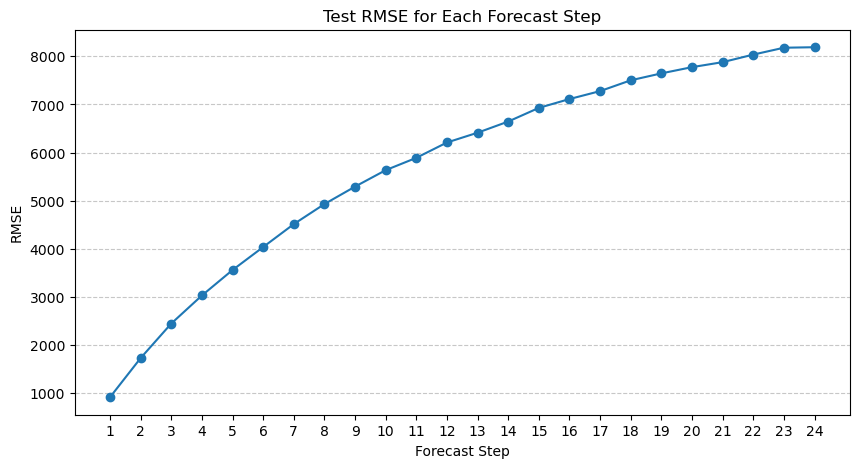

In [38]:
# Compute RMSE for each forecast step
rmses_per_step = []
for h in range(FORECAST_HORIZON):
    true_h = y_test_np[:, h]
    pred_h = predicted_means_test[:, h]
    rmse_h = root_mean_squared_error(true_h, pred_h)
    rmses_per_step.append(rmse_h)
    # print(f"Test RMSE for step {h+1}: {rmse_h:.3f}")

print(f"Average Test RMSE across horizon: {np.mean(rmses_per_step):.3f}")

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, FORECAST_HORIZON + 1), rmses_per_step, marker="o")
plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title("Test RMSE for Each Forecast Step")
plt.show()


The following boxplot shows the CRPS for each Forecast Horizon $h$ from 1 to 24 hours over the entire test set. The CRPS is a proper scoring rule that measures the sharpness and calibration of probabilistic forecasts. It takes into account both the mean and the variance of the predictions, making it a suitable metric for evaluating Gaussian Process models.

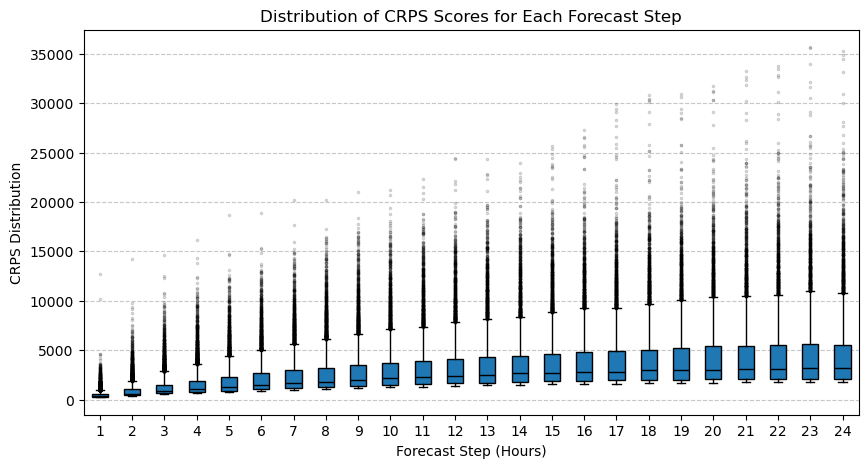

In [39]:
# Compute CRPS for each forecast step
crps_per_step = []
all_crps_samples_per_horizon = []

for h in range(FORECAST_HORIZON):
    true_h = y_test_np[:, h]
    pred_mean_h = predicted_means_test[:, h]
    pred_var_h = predicted_vars_test[:, h]
    
    pred_std_h = np.sqrt(pred_var_h)

    # Compute CRPS
    crps_samples_h = ps.crps_gaussian(
        x=true_h,
        mu=pred_mean_h,
        sig=pred_std_h
    )
    all_crps_samples_per_horizon.append(crps_samples_h)
    
    # Average CRPS for this forecast step
    crps_h = np.mean(crps_samples_h)
    crps_per_step.append(crps_h)
    
# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(1, FORECAST_HORIZON + 1), crps_per_step, marker="o")
# plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
# plt.xlabel("Forecast Step")
# plt.ylabel("CRPS")
# plt.title("Test CRPS for Each Forecast Step")
# plt.grid()
# plt.show()

plt.figure(figsize=(10, 5))
horizon_labels = [str(i + 1) for i in range(FORECAST_HORIZON)]
plt.boxplot(
    all_crps_samples_per_horizon,
    tick_labels=horizon_labels,
    patch_artist=True,
    medianprops=dict(color="black"),
    flierprops=dict(marker=".", alpha=0.2, markersize=3),
)
plt.xlabel("Forecast Step (Hours)")
plt.ylabel("CRPS Distribution")
plt.title("Distribution of CRPS Scores for Each Forecast Step")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Visualize the Predictions of the SVGP Models**

1. Find the test samples with the lowest and highest RMSE averaged over all forecast horizons.
2. Visualize the predictions of the SVGP models for these 24 hour forecasts.

In [40]:
N_BEST_SAMPLES = 1

sample_rmse_with_idx = []
for idx in range(len(y_test_np)):
    true = y_test_np[idx]
    pred = predicted_means_test[idx]
    rmse = root_mean_squared_error(true, pred)
    sample_rmse_with_idx.append((idx, rmse))
    
# Calculate the average RMSE from the rmse values
rmse_values = [x[1] for x in sample_rmse_with_idx]
print(f"Average RMSE for all samples: {np.mean(rmse_values):.3f}")

# Sort by RMSE value
sample_rmse_with_idx.sort(key=lambda x: x[1])
best_indices = [x[0] for x in sample_rmse_with_idx[:N_BEST_SAMPLES]]
worst_indices = [x[0] for x in sample_rmse_with_idx[-N_BEST_SAMPLES:]]
print(f"Best indices: {best_indices}")
print(f"Worst indices: {worst_indices}")
indices = best_indices + worst_indices

Average RMSE for all samples: 5255.483
Best indices: [8049]
Worst indices: [716]


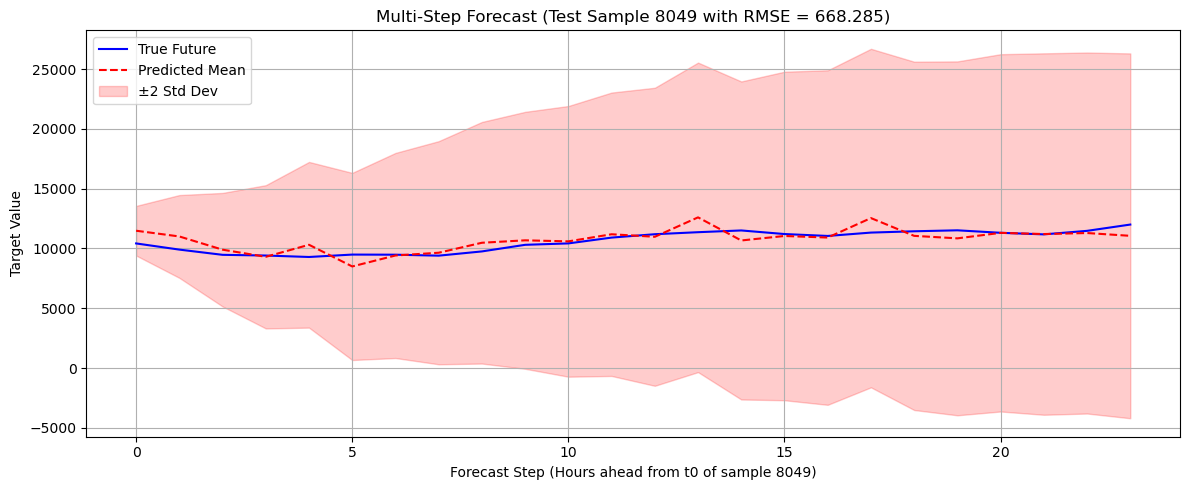

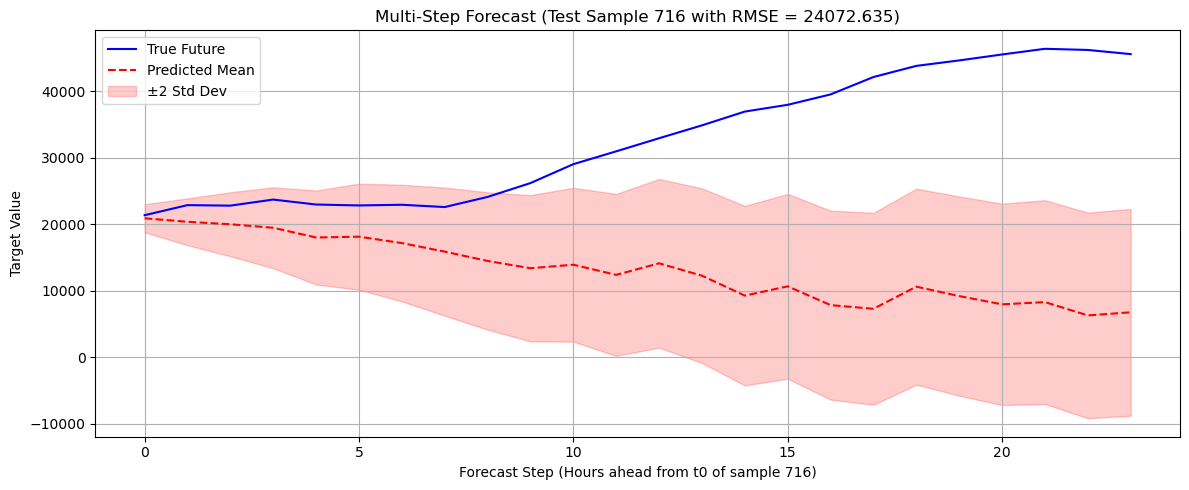

In [41]:
for i in indices:
    plt.figure(figsize=(12, 5))

    # Define the x-axis for the forecast horizon
    forecast_steps_axis = np.arange(FORECAST_HORIZON)

    # True future values for this sequence
    true_future_sequence = y_test_np[i, :]

    # Predicted future values for this sequence
    predicted_future_sequence = predicted_means_test[i, :]
    predicted_future_vars = predicted_vars_test[i, :]

    plt.plot(
        forecast_steps_axis, true_future_sequence, "b-", label="True Future"
    )
    plt.plot(
        forecast_steps_axis, predicted_future_sequence, "r--", label="Predicted Mean"
    )

    upper_bound = predicted_future_sequence + 2 * np.sqrt(predicted_future_vars)
    lower_bound = predicted_future_sequence - 2 * np.sqrt(predicted_future_vars)
    plt.fill_between(
        forecast_steps_axis,
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.2,
        label="±2 Std Dev",
    )

    plt.title(f"Multi-Step Forecast (Test Sample {i} with RMSE = {rmse_values[i]:.3f})")
    plt.xlabel(f"Forecast Step (Hours ahead from t0 of sample {i})")
    plt.ylabel("Target Value")
    # plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Visualize the Forecasts for the entire test set**

Since at each point in time we have 24 forecasts, we have a lot of overlapping predictions. I decided to to plot each day as non overlapping segments. This allows us to visualize the forecasts for the entire test set without cluttering the plot.

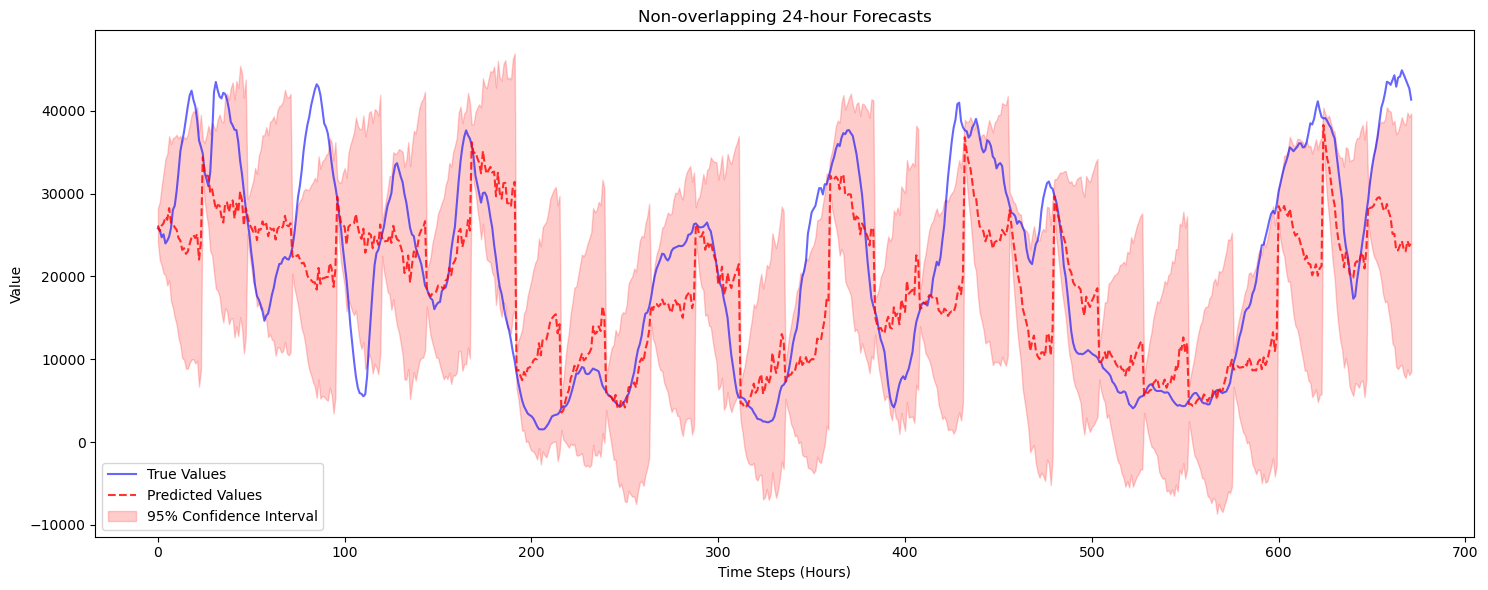

In [42]:
# ---------------------------------------
# 2. Plot along the entire test set
# ---------------------------------------
n_hours = 24 * 7 * 4 # Plot the first 7 days of the test set

# Calculate how many non-overlapping 24-hour segments we can have
number_non_overlapping_test_samples = len(y_test) // FORECAST_HORIZON

# Create time axis for the entire plot
time_axis = np.arange(number_non_overlapping_test_samples * FORECAST_HORIZON)

plt.figure(figsize=(15, 6))

# Extract actual values for the same time points we'll be forecasting
true_values = []
predicted_values = []
confidence_lower = []
confidence_upper = []

# For each non-overlapping segment
for i in range(number_non_overlapping_test_samples):
    # Get the index in the test data
    idx = i * FORECAST_HORIZON

    # Extract true values for this segment
    segment_true = y_test_np[idx]
    true_values.extend(segment_true)

    # Extract predictions for this segment
    segment_predicted = predicted_means_test[idx]
    predicted_values.extend(segment_predicted)

    # Calculate confidence intervals
    segment_vars = predicted_vars_test[idx]
    segment_lower = segment_predicted - 2 * np.sqrt(segment_vars)
    segment_upper = segment_predicted + 2 * np.sqrt(segment_vars)
    confidence_lower.extend(segment_lower)
    confidence_upper.extend(segment_upper)

# Convert to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
confidence_lower = np.array(confidence_lower)
confidence_upper = np.array(confidence_upper)

# Plot true values
plt.plot(time_axis[:n_hours], true_values[:n_hours], "b-", label="True Values", alpha=0.6)

# Plot predicted values
plt.plot(time_axis[:n_hours], predicted_values[:n_hours], "r--", label="Predicted Values", alpha=0.8)

# Plot confidence intervals
plt.fill_between(
    time_axis[:n_hours],
    confidence_lower[:n_hours],
    confidence_upper[:n_hours],
    color="red",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Add vertical lines to separate the 24-hour segments
# for i in range(1, number_non_overlapping_test_samples):
#     plt.axvline(x=i * FORECAST_HORIZON, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Time Steps (Hours)")
plt.ylabel("Value")
plt.title("Non-overlapping 24-hour Forecasts")
plt.legend()
plt.tight_layout()
plt.show()
